# Install and import libraries

In [ ]:
pip install h5py typing-extensions wheel

In [ ]:
pip install diffrax equinox jax optax sklearn scipy dtaidistance fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2952 sha256=ea9e0e24ccf449bcdffed21b315d06de5773b4c78608a9a4435ba15029a123f4
  Stored in directory: /root/.cache/pip/wheels/33/a3/d2/092b519e9522b4c91608b7dcec0dd9051fa1bff4c45f4502d1
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512707 sha256=3900ce1591707a3f46f8b5442d0554520db05880cb12f85493d1c58134102072
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built sklearn fastdtw
  Attempting uninstall: typ

In [ ]:
pip install git+https://github.com/justagist/pylasadataset

  Cloning https://github.com/justagist/pylasadataset to /tmp/pip-req-build-0_pew851
  Running command git clone --filter=blob:none --quiet https://github.com/justagist/pylasadataset /tmp/pip-req-build-0_pew851
  Resolved https://github.com/justagist/pylasadataset to commit fad83aa7049f1680114505c3f19abf0c4a2cccc8
  Preparing metadata (setup.py) ... done
  Created wheel for pyLasaDataset: filename=pyLasaDataset-0.1.1-py3-none-any.whl size=10664190 sha256=90389e7c3dfbef66ccf2e728aa08bc708891280cc2bef944c3821364a5c26dba
  Stored in directory: /tmp/pip-ephem-wheel-cache-8z733lip/wheels/e1/86/8a/d29520288612b50df39fe56a1dc9f1a26b0a11faaf028e2373
Successfully built pyLasaDataset


In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate

# Load dataset

Using LASA DataSet from /usr/local/lib/python3.10/dist-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


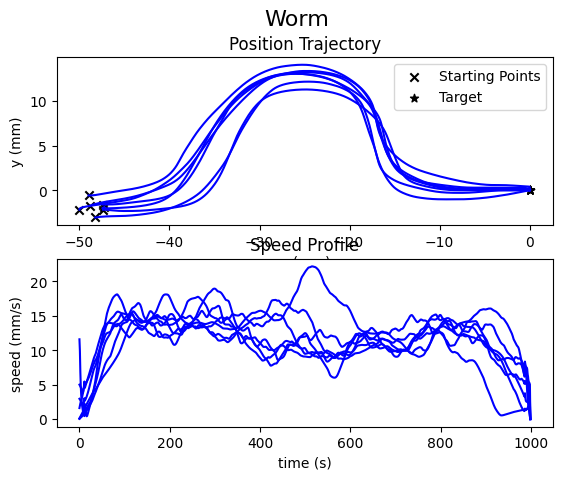

In [ ]:
import pyLasaDataset as lasa

# DataSet object has all the LASA handwriting data files
# as attributes, eg:
angle_data = lasa.DataSet.Angle
sine_data = lasa.DataSet.Sine
Leaf_2_data = lasa.DataSet.Leaf_2
CShape_data = lasa.DataSet.CShape
DoubleBendedLine = lasa.DataSet.DoubleBendedLine

data = lasa.DataSet.Worm


# Each Data object has attributes dt and demos (For documentation,
# refer original dataset repo:
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt)
dt = data.dt
demos = data.demos # list of 7 Demo objects, each corresponding to a
                         # repetition of the pattern


# Each Demo object in demos list will have attributes pos, t, vel, acc
# corresponding to the original .mat format described in
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt
demo_0 = demos[1]
pos = demo_0.pos # np.ndarray, shape: (2,2000)
vel = demo_0.vel # np.ndarray, shape: (2,2000)
acc = demo_0.acc # np.ndarray, shape: (2,2000)
t = demo_0.t # np.ndarray, shape: (1,2000)


# To visualise the data (2D position and velocity) use the plot_model utility
lasa.utilities.plot_model(data) # give any of the available
                                                   # pattern data as argument

# Define models

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, y, args):

        return self.mlp(y)

# class Func(eqx.Module):
#     mlp: eqx.nn.MLP

#     def __init__(self, data_size, width_size, depth, *, key, **kwargs):
#         super().__init__(**kwargs)
#         self.mlp = eqx.nn.MLP(
#             in_size=data_size,
#             out_size=data_size,
#             width_size=width_size,
#             depth=depth,
#             activation=jnn.softplus,
#             key=key,
#         )

#     def __call__(self, t, y, args):
#         return self.mlp(y) - y

In [ ]:
class Funcd(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=2*data_size,
            out_size=2*data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, yd, args):

        return self.mlp(yd)
        # return self.mlp(jnp.concatenate([yd, jnp.array([t])]))

In [ ]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [ ]:
class NeuralODEd(eqx.Module):
    func: Funcd

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Funcd(data_size, width_size, depth, key=key)

    @eqx.filter_jit
    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys


# Process data. batch_size $\neq$ dataset_size

In [ ]:
ndemos = len(demos)
T = demos[0].t.shape[-1]
pos_all = []
vel_all = []
for i in range(ndemos):
  pos_all.append((demos[i].pos).T)
  vel_all.append((demos[i].vel).T)
posn = jnp.array(pos_all)
veln = jnp.array(vel_all)
tn =  jnp.array(t.T).reshape(T)
ys_all_n = jnp.concatenate((posn,veln),axis=2)

In [ ]:
nsamples = 1000
ts = t[0]/t[0, -1]
ts_new = jnp.linspace(0, 1, nsamples)

dim = posn.shape[2]

traj_process = jnp.zeros((ndemos, nsamples, dim))
vel_process = jnp.zeros((ndemos, nsamples, dim))

traj_all_t_norm = []
# time_all_process = jnp.zeros((traj_c, nsamples))

seed = 1385

key = jax.random.PRNGKey(seed)
scale_state = 1

key_trajs = jax.random.split(key, num=ndemos)

for i in range(ndemos):
  key_dim = jax.random.split(key_trajs[i], num=dim)
  for j in range(dim):
    f = interpolate.interp1d(ts, posn[i, :, j])
    f_vel = interpolate.interp1d(ts, veln[i, :, j])
    # f = interpolate.interp1d(time_all[i][:, 0], traj_all[i][:, j])
    # ts_new = np.linspace(time_all[i][0, 0], time_all[i][-1, 0], nsamples)
    # time_all_process = time_all_process.at[i].set(ts_new)
    traj_new = f(ts_new)
    vel_new = f_vel(ts_new)
    traj_process = traj_process.at[i, :, j].set(scale_state*traj_new)
    vel_process = vel_process.at[i, :, j].set(scale_state*vel_new)

## Train_Test_split

nTD = 4
traj_train = traj_process[1:nTD]
vel_train = vel_process[1:nTD]

traj_test = traj_process[nTD:]
vel_test = vel_process[nTD:]

## Multi_models

# train_indx = [0, 2, 4, 6]
# nTD = len(train_indx)
# traj_train = jnp.zeros((len(train_indx), nsamples, dim))
# vel_train = jnp.zeros((len(train_indx), nsamples, dim))
# c=0

# for i in train_indx:
#   traj_train = traj_train.at[c].set(traj_process[i])
#   vel_train = vel_train.at[c].set(vel_process[i])
#   c += 1

# test_indx = [1, 3, 5]
# traj_test = jnp.zeros((len(test_indx), nsamples, dim))
# vel_test = jnp.zeros((len(test_indx), nsamples, dim))
# c=0

# for i in test_indx:
#   traj_test = traj_test.at[c].set(traj_process[i])
#   vel_test = vel_test.at[c].set(vel_process[i])
#   c += 1

traj_all_train = jnp.concatenate((traj_train, vel_train), axis=2)
traj_all_test = jnp.concatenate((traj_test, vel_test), axis=2)

# Dataloader

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

# Load the models

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/LASA_models/CoRL_2023/Worm_checkpoint.eqx"
# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Tunnel_no_d_checkpoint.eqx"
ys = posn
ts = tn
ys_dot = veln
_, length_size, data_size = ys.shape
width_size=64
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE(data_size, width_size, depth, key=model_key)
model = eqx.tree_deserialise_leaves(file_name, model1)

# Plot predicted trajectories

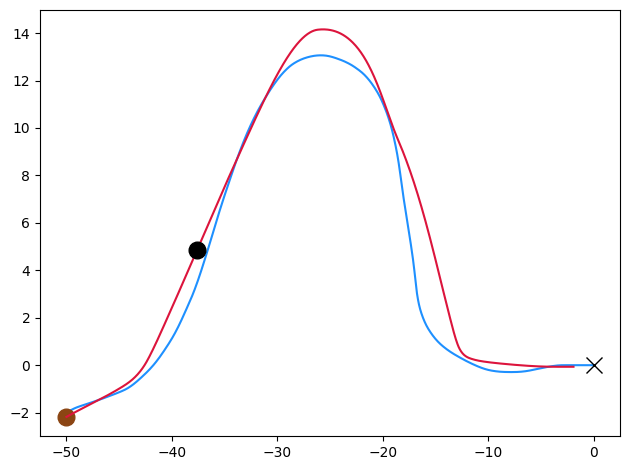

In [ ]:
train_indx = 5
plt.plot(posn[train_indx, :, 0], posn[train_indx, :, 1], c="dodgerblue", label="Real")
plt.plot(posn[train_indx, 0, 0], posn[train_indx, 0, 1], c="saddlebrown", marker='o', markersize = '12', label="Start")
plt.plot(posn[train_indx, -1, 0], posn[train_indx, -1, 1], c="black", marker='x', markersize = '12', label="Target")
model_y = model(ts, posn[train_indx, 0])
plt.plot(model_y[:, 0], model_y[:, 1], c="crimson", label="Model")
dist_indx = 260
plt.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], c="black", marker='o', markersize = '12', label="Disturbance")
# plt.legend()
plt.tight_layout()
# plt.savefig("neural_ode.png")
plt.show()

# CBF-CLF QP implementation

In [ ]:
import numpy as np
import cvxpy as cp

indx = train_indx
ys = posn
model_load = model
f = lambda t, z : model_load.func(t, z, _)
xref = model_load(ts, ys[indx, 0, :])
x = posn[indx, 0]
r = jnp.array([10]) # Obstacle radius
c = jnp.array([-25, 25]) # Obstacle center
xall = jnp.expand_dims(x, axis=0)

vopt_all = []

dti = ts[1] - ts[0]

cmd_vel =jnp.array([[0, 0]])

for i in range(int(1*len(ts)-1)):

  if(i==dist_indx):
    # indx = indx_angle
    # model_load = model_load_angle
    # dist_point = jnp.array([-18, -9])
    dist_point = jnp.array([-50, 15]) # Worm
    x = dist_point

  # if(i==600):
  #   indx = indx_spoon
  #   model_load = model_load_spoon
  #   ys = posn_spoon
  #   f = lambda z : model_load.func(_, z, _)

  x_t=np.asarray(x)

  # xref = np.asarray(ys[indx,i,:])

  t0i = 0

  tsi = jnp.array([0, dti])
  # tsi_d = jnp.array([ts[i], ts[i+1]])

  xref_t = np.asarray(xref[i, :])

  ## Only disturbance

  alpha_h = 10
  gamma = 0.1
  lambda_v = 0

  Q = np.eye(x_t.shape[0])
  G = 2*((x_t-xref_t).T)
  fx_t = np.asarray(f(ts[i], x_t))
  fxref_t = np.asarray(f(ts[i], xref_t))
  # h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) + alpha_h*(-(((x_t-xref_t).T)@(x_t-xref_t)) + r**2) # CBF
  h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) - alpha_h*((((x_t-xref_t).T)@(x_t-xref_t))) # CLF
  # h = -(alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma)

  # h = alpha_h*(((x1-xref_t).T)@(x1-xref_t))+gamma

  # h = alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma

  vopt = cp.Variable(x_t.shape[0])
  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)  + lambda_v*cp.pos(G @ vopt - h)),
                  [G @ vopt <= h])

  ## With obstacle

  # alpha_L = 4
  # alpha_B = 5
  # lambda_v = 0.5

  # Q = np.eye(x_t.shape[0])
  # G_L = 2*((x_t-xref_t).T)
  # G_B = -2*((x_t-c).T)
  # fx_t = np.asarray(f(ts[i], x_t))
  # fxref_t = np.asarray(f(ts[i], xref_t))
  # h_B = 2*(((x_t-c).T)@(fx_t)) + alpha_B*((((x_t-c).T)@(x_t-c)) - r**2) # CBF
  # h_L = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) - alpha_L*((((x_t-xref_t).T)@(x_t-xref_t))) # CLF
  # # h = -(alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma)

  # h = alpha_h*(((x1-xref_t).T)@(x1-xref_t))+gamma

  # h = alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma

  # vopt = cp.Variable(x_t.shape[0])
  # epsilon = cp.Variable((1,1))
  # prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)  + lambda_v*cp.quad_form(epsilon, np.eye(1))),
  #                 [G_L @ vopt - epsilon <= h_L,
  #                  G_B @ vopt <= h_B])

  prob.solve()

  f1 = lambda z : model_load.func(_, z,_) + vopt.value

  ## Switching mode

  # f1 = lambda z : model_load.func(_, z,_)

  # x = jnp.asarray(x1)

  # f1 = lambda t, z, args : model_load.func(t, z, _) + vopt.value
  # solution = diffrax.diffeqsolve(
  #     diffrax.ODETerm(f1),
  #     diffrax.Tsit5(),
  #     t0=ts[i],
  #     t1=ts[i+1],
  #     dt0=dti,
  #     y0=x,
  #     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
  #     saveat=diffrax.SaveAt(ts=tsi_d),
  # )

  # vopt_all.append(np.linalg.norm(vopt.value))

  xnext = f1(x)*dti + x

  # xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)

  cmd_vel = jnp.append(cmd_vel, jnp.expand_dims(f1(x), axis=0), axis=0)

  x = xnext

  if(i%10==0):
    print(f"Time: {i}, Position: {x}")

Time: 0, Position: [-49.953697   -2.1685781]
Time: 10, Position: [-49.49131    -2.0549643]
Time: 20, Position: [-49.02969    -1.9452789]
Time: 30, Position: [-48.568344   -1.8379968]
Time: 40, Position: [-48.106903   -1.7320465]
Time: 50, Position: [-47.64508    -1.6265838]
Time: 60, Position: [-47.182594   -1.5208257]
Time: 70, Position: [-46.719147   -1.4139242]
Time: 80, Position: [-46.254356   -1.3048605]
Time: 90, Position: [-45.78779    -1.1923333]
Time: 100, Position: [-45.318844   -1.0746136]
Time: 110, Position: [-44.846783    -0.94928193]
Time: 120, Position: [-44.370907    -0.81316423]
Time: 130, Position: [-43.889767   -0.6588964]
Time: 140, Position: [-43.400818    -0.46919474]
Time: 150, Position: [-42.903515    -0.21444333]
Time: 160, Position: [-42.40564      0.12960161]
Time: 170, Position: [-41.91437     0.5481998]
Time: 180, Position: [-41.427135    1.0041963]
Time: 190, Position: [-40.941277    1.4771075]
Time: 200, Position: [-40.45592     1.9590485]
Time: 210, Pos

# Plot predicted vector field and disturbed trajectories

(-14.0, 19.0)

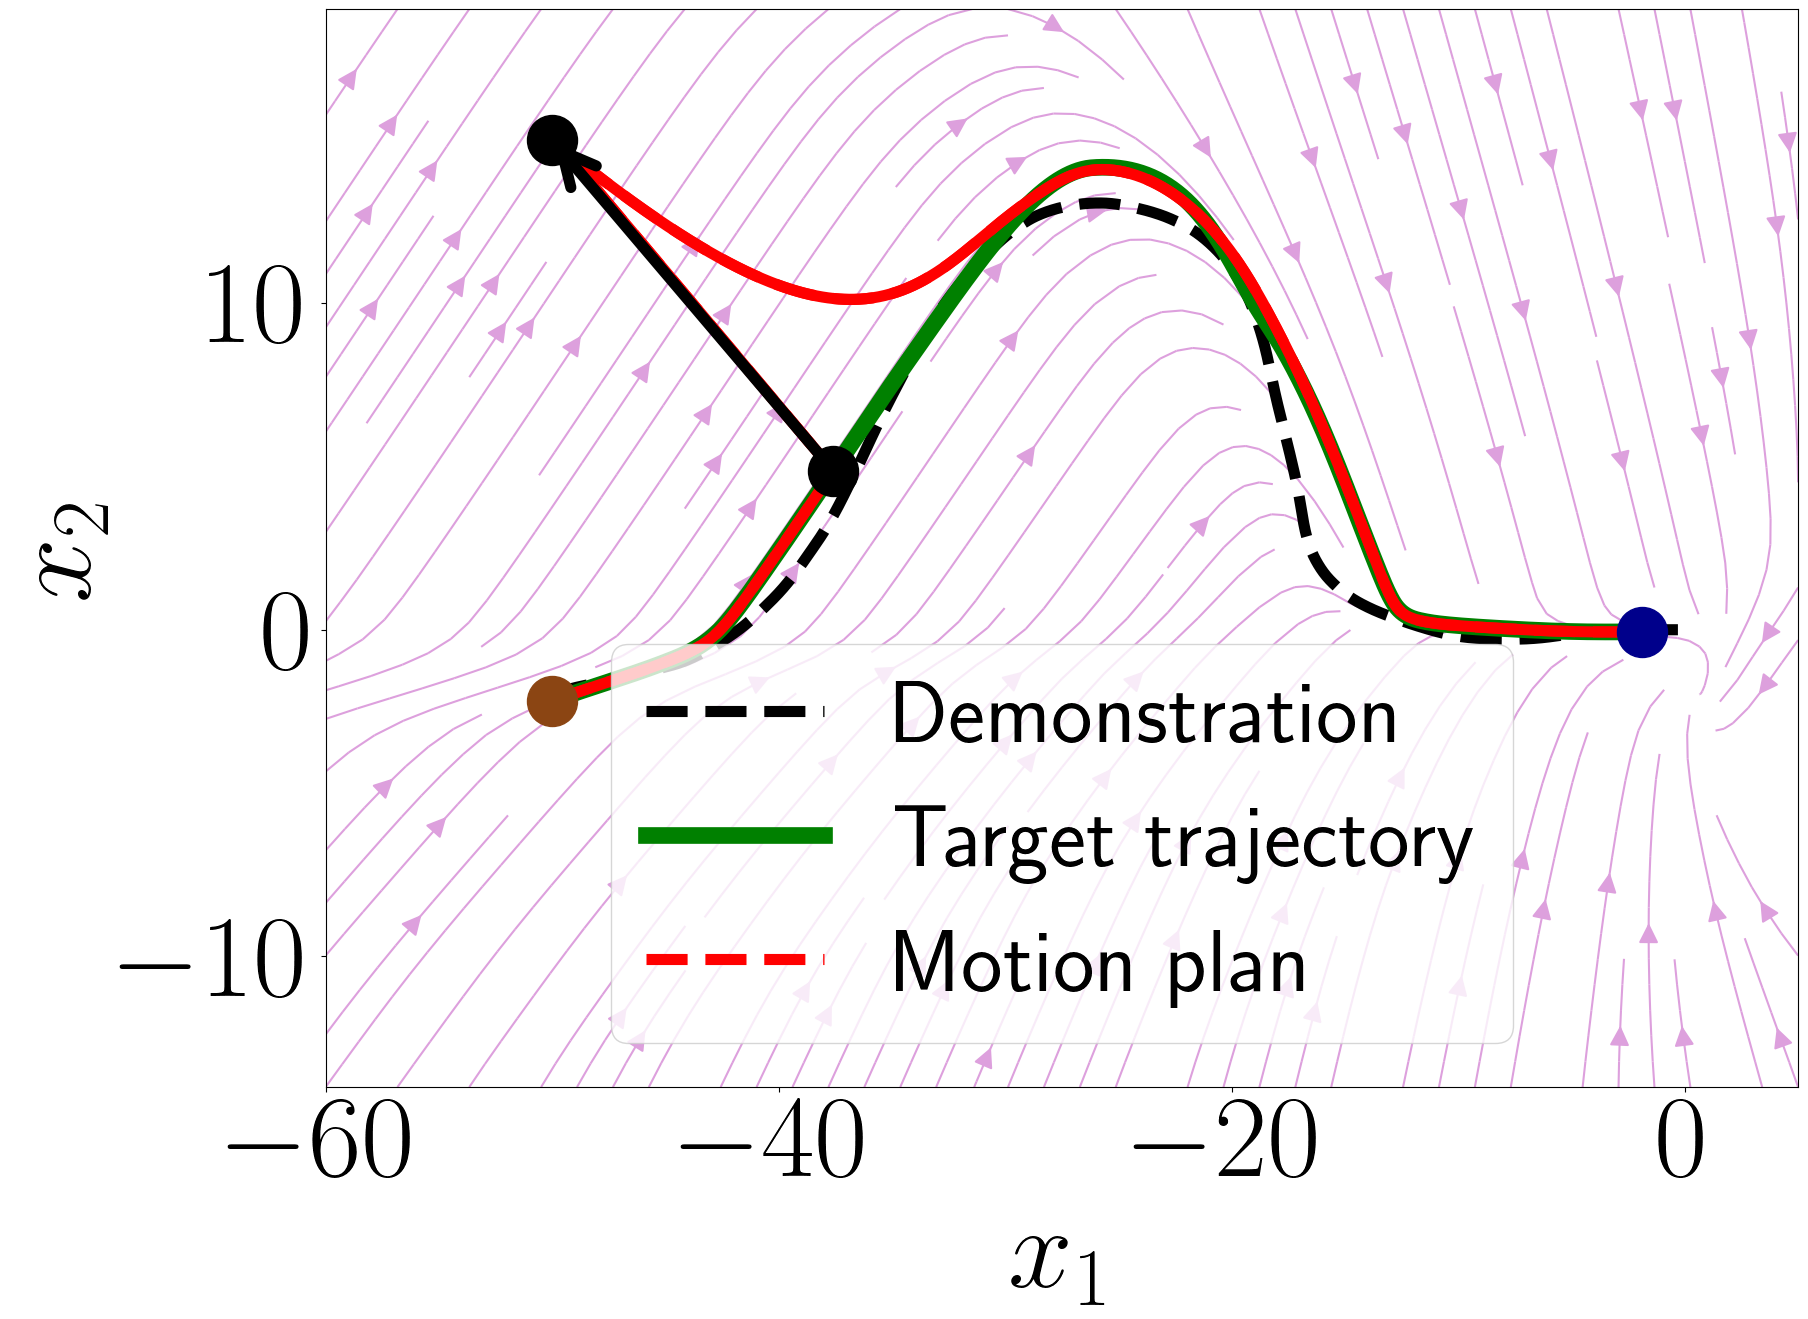

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'size': 84}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})

def streamQuiver(ax,sp,*args,spacing=None,n=5,**kwargs):
    """ Plot arrows from streamplot data
    The number of arrows per streamline is controlled either by `spacing` or by `n`.
    See `lines_to_arrows`.
    """
    def curve_coord(line=None):
        """ return curvilinear coordinate """
        x=line[:,0]
        y=line[:,1]
        s     = np.zeros(x.shape)
        s[1:] = np.sqrt((x[1:]-x[0:-1])**2+ (y[1:]-y[0:-1])**2)
        s     = np.cumsum(s)
        return s

    def curve_extract(line,spacing,offset=None):
        """ Extract points at equidistant space along a curve"""
        x=line[:,0]
        y=line[:,1]
        if offset is None:
            offset=spacing/2
        # Computing curvilinear length
        s = curve_coord(line)
        offset=np.mod(offset,s[-1]) # making sure we always get one point
        # New (equidistant) curvilinear coordinate
        sExtract=np.arange(offset,s[-1],spacing)
        # Interpolating based on new curvilinear coordinate
        xx=np.interp(sExtract,s,x);
        yy=np.interp(sExtract,s,y);
        return np.array([xx,yy]).T

    def seg_to_lines(seg):
        """ Convert a list of segments to a list of lines """
        def extract_continuous(i):
            x=[]
            y=[]
            # Special case, we have only 1 segment remaining:
            if i==len(seg)-1:
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                x.append(seg[i][1,0])
                y.append(seg[i][1,1])
                return i,x,y
            # Looping on continuous segment
            while i<len(seg)-1:
                # Adding our start point
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                # Checking whether next segment continues our line
                Continuous= all(seg[i][1,:]==seg[i+1][0,:])
                if not Continuous:
                    # We add our end point then
                    x.append(seg[i][1,0])
                    y.append(seg[i][1,1])
                    break
                elif i==len(seg)-2:
                    # we add the last segment
                    x.append(seg[i+1][0,0])
                    y.append(seg[i+1][0,1])
                    x.append(seg[i+1][1,0])
                    y.append(seg[i+1][1,1])
                i=i+1
            return i,x,y
        lines=[]
        i=0
        while i<len(seg):
            iEnd,x,y=extract_continuous(i)
            lines.append(np.array( [x,y] ).T)
            i=iEnd+1
        return lines

    def lines_to_arrows(lines,n=5,spacing=None,normalize=True):
        """ Extract "streamlines" arrows from a set of lines
        Either: `n` arrows per line
            or an arrow every `spacing` distance
        If `normalize` is true, the arrows have a unit length
        """
        if spacing is None:
            # if n is provided we estimate the spacing based on each curve lenght)
            spacing = [ curve_coord(l)[-1]/n for l in lines]
        try:
            len(spacing)
        except:
            spacing=[spacing]*len(lines)

        lines_s=[curve_extract(l,spacing=sp,offset=sp/2)         for l,sp in zip(lines,spacing)]
        lines_e=[curve_extract(l,spacing=sp,offset=sp/2+0.01*sp) for l,sp in zip(lines,spacing)]
        arrow_x  = [l[i,0] for l in lines_s for i in range(len(l))]
        arrow_y  = [l[i,1] for l in lines_s for i in range(len(l))]
        arrow_dx = [le[i,0]-ls[i,0] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]
        arrow_dy = [le[i,1]-ls[i,1] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]

        if normalize:
            dn = [ np.sqrt(ddx**2 + ddy**2) for ddx,ddy in zip(arrow_dx,arrow_dy)]
            arrow_dx = [ddx/ddn for ddx,ddn in zip(arrow_dx,dn)]
            arrow_dy = [ddy/ddn for ddy,ddn in zip(arrow_dy,dn)]
        return  arrow_x,arrow_y,arrow_dx,arrow_dy

    # --- Main body of streamQuiver
    # Extracting lines
    seg   = sp.lines.get_segments() # list of (2, 2) numpy arrays
    lines = seg_to_lines(seg)       # list of (N,2) numpy arrays
    # Convert lines to arrows
    ar_x, ar_y, ar_dx, ar_dy = lines_to_arrows(lines,spacing=spacing,n=n,normalize=True)
    # Plot arrows
    qv=ax.quiver(ar_x, ar_y, ar_dx, ar_dy, *args, angles='xy', **kwargs)
    return qv

## Worm disturbance
xmin = -60
xmax = 5
ymin = -14
ymax = 19

## Trapexoid obstacle
# xmin = -60
# xmax = 10
# ymin = -10
# ymax = 40

indx = train_indx

f = lambda z : model.func(_, z, _)

(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(19,14))
x, y = np.meshgrid(np.linspace(xmin, xmax, 50),
                   np.linspace(ymin, ymax, 50))
xy_vec = np.hstack((x.reshape((x.size, -1)), y.reshape((y.size, -1))))
uv_vec = jax.vmap(f, in_axes=0)(xy_vec)
proj_uv = uv_vec
u = proj_uv[:, 0].reshape((x.shape[0], x.shape[0]))
v = proj_uv[:, 1].reshape((y.shape[0], y.shape[0]))
sp = ax.streamplot(x, y, u ,v, arrowsize = 3, density=1.4, color='plum') #, arrowstyle='->', density=1, arrowsize=0.1)
# streamQuiver(ax, sp, n=10, color='plum', width = 0.01)
# fig = go.Figure()
model_y = model(ts, ys[indx, 0])
g_indx = -1
# ax.annotate('Start', xy=(model_y[0, 0], model_y[0, 1]), xytext=(-50, 25), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Goal', xy=(model_y[g_indx, 0], model_y[g_indx, 1]), xytext=(-30, 0), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
## Switch mode
ax.plot(posn[indx, :, 0], posn[indx, :, 1], c="black", linestyle='--', linewidth='8', label="Demonstration")
ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='12', label="Target trajectory")
# model_y_1 = model(ts, posn[indx, 0])
# ax.plot(model_y_1[ :, 0], model_y_1[ :, 1], c="green", linewidth='3')
# switch_indx = 2
# model_y_2 = model(ts, posn[switch_indx, 0])
# ax.plot(model_y_2[ :, 0], model_y_2[ :, 1], c="green", linewidth='3')
# ax.plot(posn[switch_indx, :, 0], posn[switch_indx, :, 1], c="black", linestyle='--', linewidth='3')
# # ax.annotate('Switch mode', xy=(dist_point[0], dist_point[1]), xytext=(-10, -30), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate("", xy=(dist_point[0], dist_point[1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]),
#             arrowprops=dict(mutation_scale=30, arrowstyle="->", linewidth=3)) # Arrow


ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='8', linestyle='--', label="Motion plan")

model_y_dist = model_load(ts, dist_point)
# ax.plot(model_y_dist[:, 0], model_y_dist[:, 1], c="crimson", linewidth='3')

## Obstacle
# xc = c
# circle = plt.Circle((xc), r, color='dodgerblue', fill=1, alpha=0.5)
# ax.add_artist(circle)

# ax.plot(model_y_dist[:, 0], model_y_dist[:, 1], c="red", linewidth='4', label="Without correction", linestyle='--')
ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='8')
# ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# plt.plot(np.array([model_y[130, 0], model_y_dist[0, 0]]), np.array([model_y[130, 1], model_y_dist[0, 1]]), c="green", linewidth='2', label="Disturbance", linestyle='--')
# plt.arrow(model_y[130, 0], model_y[130, 1], model_y_dist[0, 0] - model_y[130, 0], model_y_dist[0, 1] - model_y[130, 1])
## Disturbance
# # ax.annotate('Disturbance', xy=(dist_point[0], dist_point[1]), xytext=(-10, 15), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))

ax.plot(model_y[0, 0], model_y[0, 1], marker="o", markersize=36, c="saddlebrown")
ax.plot(model_y[-1, 0], model_y[-1, 1], marker="o", markersize=36, c="darkblue")
alpha = 7
alpha_n = 12
ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", markersize=36, c="black")
ax.plot(dist_point[0], dist_point[1], marker="o", markersize=36, c="black")
ax.annotate("", xy=(dist_point[0], dist_point[1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]),
            arrowprops=dict(mutation_scale=60, arrowstyle="->", linewidth=8)) # Arrow
# plt.plot(traj_all_process[indx, 0, 0], traj_all_process[indx, 0, 1], 'ro')
# plt.plot(traj_all_process[indx, -1, 0], traj_all_process[indx, -1, 1], 'go')
# ax.plot(ys[indx, :, 0], ys[indx, :, 1], ys[indx, :, 2], c='red', label='Demonstration')
ax.legend(loc='lower center', fontsize=64)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# ax.set_xlabel('x')
# plt.tight_layout()
# ax.show()

Model parameters:

Line:

lr_strategy=(3e-3,),
steps_strategy=(5000,),
length_strategy=(1,),
width_size=32,
depth=3,

Saeghe:

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

BendedLine(okayish), Zshape, Worm:

lr_strategy=(4e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

Trapezoid, Sine, Wshape(bad):

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Angle:

lr_strategy=(4e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Leaf_1:

lr_strategy=(3e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=5,

L/J2/J/GShape:

lr_strategy=(6e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

RShape, PShape:

lr_strategy=(6e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=64,
depth=3,

Sshape, Snake, Sharpc:

lr_strategy=(4e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,

Multi_Models_1, 3, 4:

lr_strategy=(6e-4,),
steps_strategy=(8000,),
length_strategy=(1,),
width_size=128,
depth=3,

Leaf_2: width_size = 128

Khmahesh(bad), Hee:

lr_strategy=(2e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=128,
depth=3,

Multi_Models_2, DoubleBendedLine, CShape, Spoon, NShape:

lr_strategy=(9e-4,),
steps_strategy=(7000,),
length_strategy=(1,),
width_size=64,
depth=3,